# Panduan Menggunakan TensorFlow Lite untuk Mobile Devices

Pada pelajaran sebelumnya, Anda mendapatkan gambaran umum tentang TensorFlow Lite dan prinsip dasar yang mengaturnya. Anda melihat bagaimana kebutuhan perangkat dengan daya rendah memaksa Anda untuk memodifikasi model, memperkecil dan menyederhanakannya, serta mempelajari konsep optimisasi melalui teknik-teknik seperti *quantization*. Pada pelajaran ini, Anda akan lebih banyak berlatih dan melihat bagaimana cara menyimpan model, mengkonversinya, dan mengoptimalkannya untuk perangkat mobile Anda. Secara ringkas, proses yang akan Anda lakukan akan terlihat seperti ini:

1. **Melatih Model dengan TensorFlow**: Anda akan melatih model menggunakan TensorFlow.
2. **Menyimpan Model sebagai SavedModel**: Setelah model dilatih, Anda akan menyimpannya dalam format SavedModel.
3. **Menggunakan TFLite Converter**: Anda akan menggunakan TFLite converter untuk menghasilkan model TFLite.
   
### Apa itu TFLite Converter?
Ketika Anda membuat model dengan TensorFlow menggunakan API Keras atau API tingkat rendah, Anda akan menyimpannya sebagai model Keras, SavedModel, atau serangkaian fungsi konkrit dalam memori. *Converter* ini mengambil model-model tersebut dan mengkonversinya ke format `.TFlite`, yang merupakan buffer datar yang kemudian dapat digunakan pada perangkat mobile bersama dengan backend opsional seperti Neural Network APIs atau GPU.

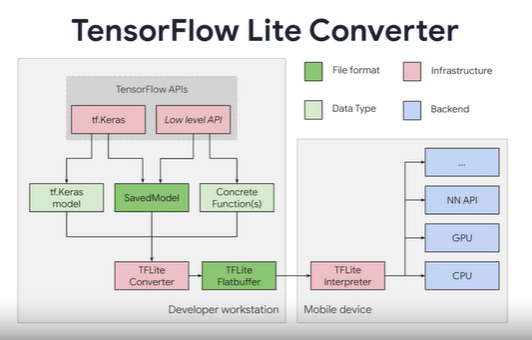

Di Python, pada workstation pengembang Anda, Anda dapat memanggil `tf.lite.TFLiteConverter` untuk melakukan konversi. Bergantung pada bagaimana model Anda direpresentasikan, Anda dapat menginstansiasinya dari SavedModel, model Keras, atau dari fungsi konkrit untuk mendapatkan output.

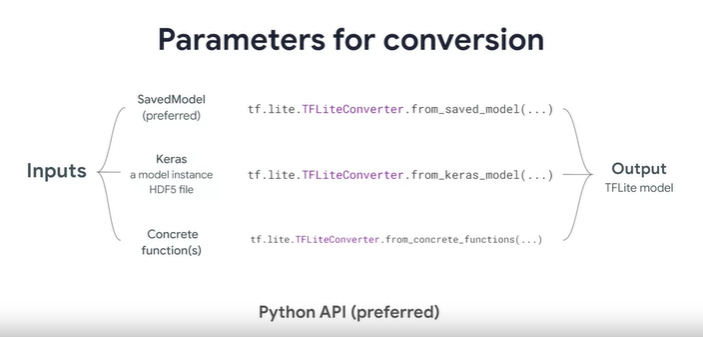

### Format SavedModel
Metodologi standar yang disarankan untuk menyimpan model di TensorFlow 2.0 adalah format **SavedModel**. Format ini dirancang untuk menjadi cara serialisasi model TensorFlow yang universal, netral bahasa, dan dapat dipulihkan. Format ini memudahkan sistem tingkat tinggi untuk menghasilkan, mengubah, dan mengonsumsi model TensorFlow menggunakan satu abstraksi tunggal. Dengan SavedModel, Anda bisa melupakan kode yang digunakan untuk membangun model, membuatnya lebih mudah untuk dibagikan dan dideploy dengan TensorFlow Lite, TensorFlow.js, TensorFlow Serving, dan TensorFlow Hub.

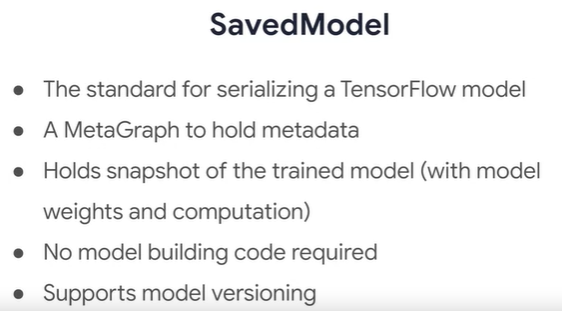

### MetaGraph dan Signatures
Saat **SavedModel** diekspor, sebuah **MetaGraph** akan dibuat. MetaGraph ini pada dasarnya adalah grafik aliran data yang mencakup variabel yang terkait dengan model, serta aset tambahan seperti daftar label atau kelas yang mungkin diperlukan bersama dengan signature untuk prediksi. Misalnya, signature klasifikasi dalam kasus klasifikasi gambar.

### Menggunakan SavedModel CLI
Untuk memahami antarmuka dari signature-model yang disimpan, Anda dapat menjalankan skrip **SavedModel CLI** untuk mendapatkan detailnya dengan kode seperti berikut:

```bash
saved_model_cli show --dir /path/to/savedmodel --tag_set serve --signature_def serving_default


# Post-Training Quantization di TensorFlow Lite

Kita telah banyak membicarakan tentang **quantization**. Salah satu metode sederhana untuk mencapai ini adalah **post-training quantization**. Dalam kasus ini, alih-alih melakukan quantization pada model selama pelatihan (yang akan mengubah kode pelatihan), kita melakukan quantization saat proses konversi model ke format **TF-lite**.

Pada dasarnya, metode ini mengonversi semua nilai float pada bobot model menjadi integer (int). Hasilnya, Anda akan mendapatkan latensi yang jauh lebih baik, yang berdasarkan eksperimen dapat mengurangi latensi hingga tiga kali lebih cepat dengan penurunan akurasi model yang relatif minor.

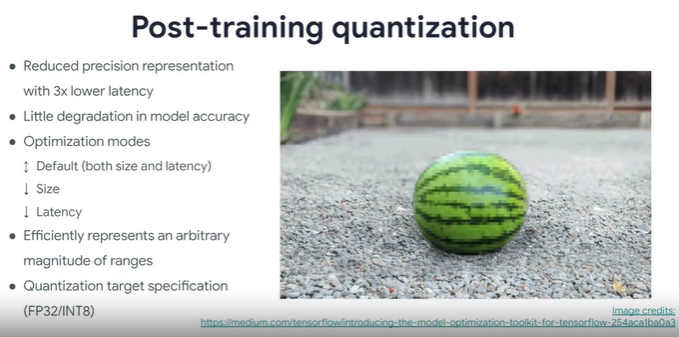

### Konverter Default
Secara default, konverter akan mengoptimalkan ukuran dan latensi model. Namun, Anda bisa mengubah pengaturan ini dalam kode untuk mengutamakan salah satu di antaranya. Berikut adalah contoh di mana kita mengubah perilaku default konverter untuk mengutamakan ukuran model.

### Pengaturan untuk Optimasi
1. Anda bisa mengonfigurasi agar konverter mengoptimalkan ukuran untuk memperkecil ukuran model.
2. Anda juga bisa memilih untuk mengoptimalkan latensi guna mendapatkan performa yang lebih baik.
3. Atau, biarkan pengaturan default di mana konverter mencoba mencari keseimbangan terbaik antara ukuran dan latensi.

### Integer Quantization untuk Edge TPUs
Pada beberapa perangkat seperti **Edge TPUs**, akselerator hanya mendukung operasi integer. Oleh karena itu, toolkit optimasi memungkinkan kita untuk melakukan **post-training integer quantization**, yang dapat membuat model menjadi hingga empat kali lebih kecil.

### Proses Optimasi dengan Data Kalibrasi
Selanjutnya, kita bisa melakukan optimasi lebih lanjut dengan menggunakan **calibration data**, yaitu dengan menjalankan inferensi pada sekumpulan input kecil untuk menentukan parameter skala yang tepat saat mengonversi model ke format quantization integer.

Berikut adalah contoh langkah-langkah konversi **SavedModel** ke **TensorFlow Lite** dengan **post-training integer quantization**:

```python
import tensorflow as tf

# Definisikan generator untuk menghasilkan sampel dari dataset
def representative_data_gen():
    for input_value in dataset.take(100):
        yield [input_value]

# Konversi model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optimasi untuk ukuran dan latensi
converter.representative_dataset = representative_data_gen

# Konversi model ke format TF Lite dengan integer quantization
tflite_model = converter.convert()

# Simpan model yang telah terkonversi
with open('model_quantized.tflite', 'wb') as f:
    f.write(tflite_model)
```

Penjelasan Proses
Generator Data Representatif: Ini digunakan untuk mengevaluasi optimasi dengan merekam rentang dinamis. Dengan menjalankan beberapa inferensi pada model TensorFlow Lite bertipe float, kita dapat menentukan parameter skala yang dibutuhkan untuk mengonversi model menggunakan integer arithmetic.

Quantization Ops: Model yang dihasilkan akan memiliki operasi quantized sebanyak mungkin. Untuk operasi yang tidak memiliki implementasi quantized, konverter akan menggunakan operasi berbasis float, memungkinkan model tetap menerima input dan output float demi kenyamanan.

Perangkat Akselerator Khusus: Jika perangkat hanya mendukung operasi integer (misalnya, Edge TPUs), kita cukup memberitahukan konverter untuk hanya menghasilkan output integer dengan membatasi spesifikasi target quantization ke TensorFlow Lite INT8 built-in ops.

Catatan Penting
Jika konverter menemukan operasi yang saat ini tidak bisa dilakukan quantization, maka akan muncul error.

Dengan menggunakan teknik ini, kita bisa memastikan bahwa model siap digunakan pada perangkat yang hanya mendukung operasi integer, sambil tetap menjaga performa dan ukuran model seoptimal mungkin.